#災害データ分析から読み解く被害特性とリスク課題

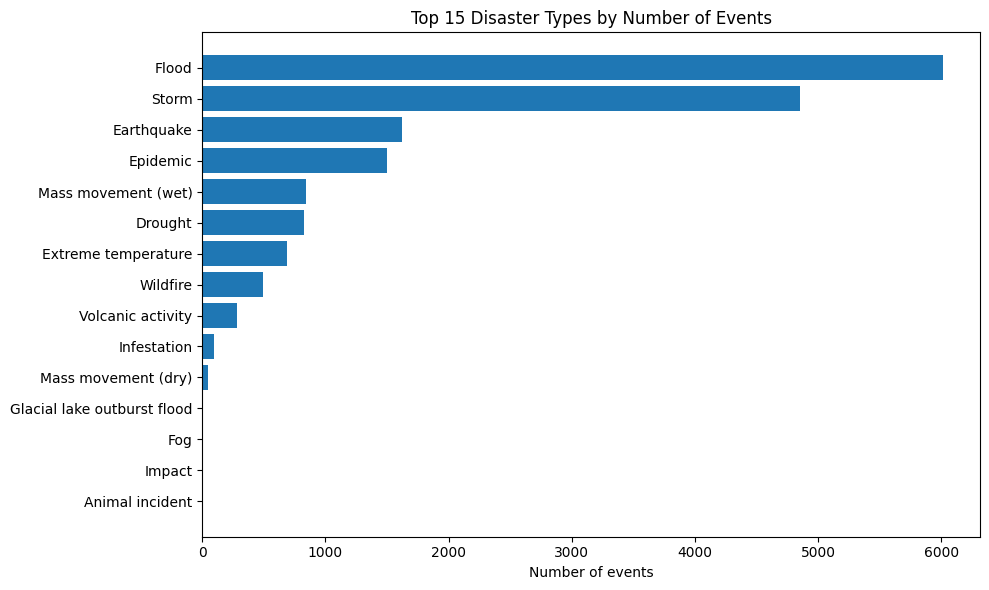

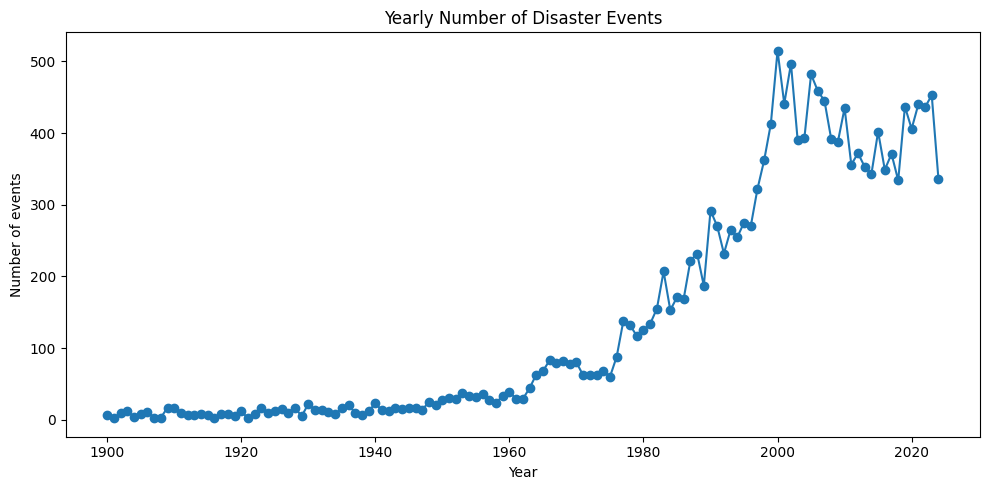

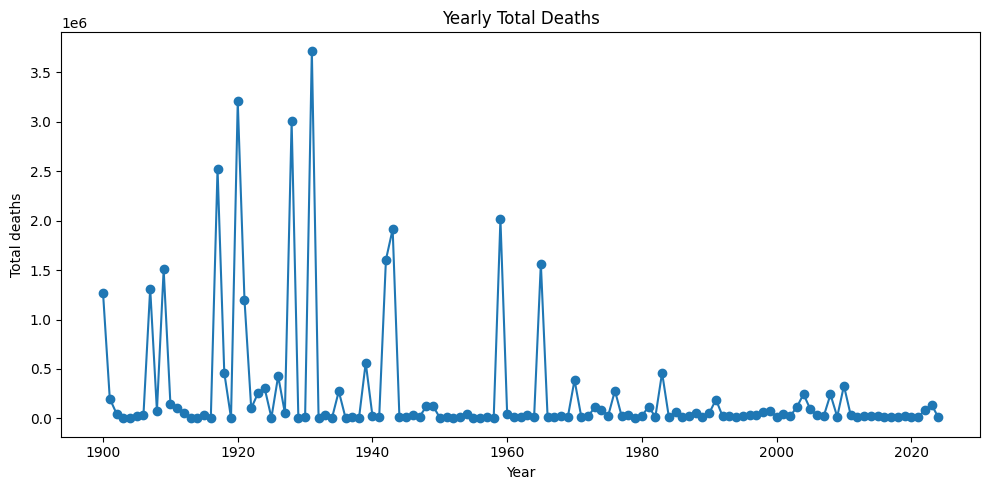

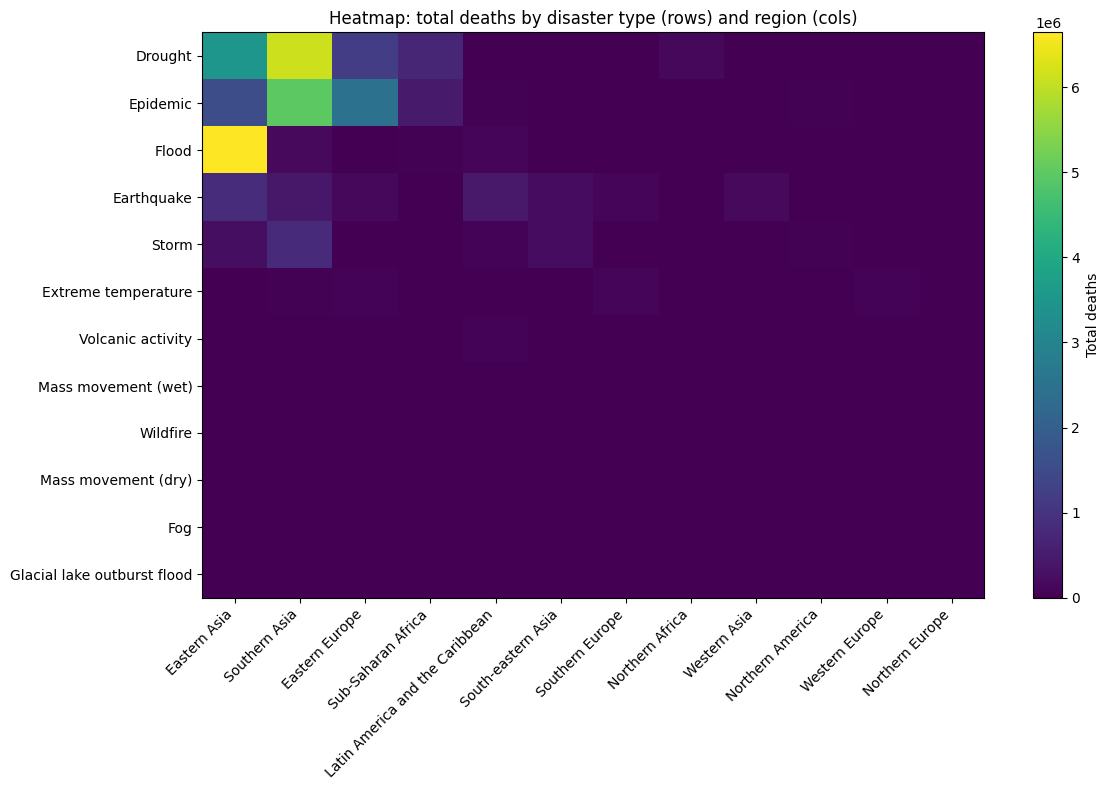

=== 自動抽出された洞察 ===
- 最も頻度の高い災害種別は 'Flood'（記録数 = 6014 件）です。
- 総死者数が最も多い災害種別は 'Drought'（合計死者数 = 11734272 人）です。
- 最も死者数が多い地域は 'Eastern Asia'（合計死者数 = 12817383 人）です。
- 死者数ピークの年（上位3）は: 1931年(3718976人), 1920年(3206872人), 1928年(3004895人) です。


In [2]:
# emdat_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 設定: ファイルパスを書き換えてください ---
file_path = "emdat.csv"  # または "/mnt/data/emdat.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found. Place the CSV in the working directory or change file_path.")

# 1) 読み込み
df = pd.read_csv(file_path, low_memory=False)

# 2) カラム名を推定して標準化（汎用的な処理）
cols = list(df.columns)
lower = {c.lower(): c for c in cols}

def find_col(keywords):
    for k, orig in lower.items():
        if all(w in k for w in keywords):
            return orig
    return None

# 推定: 年, 災害種別, 地域, 国, 死者数, 被災者数
year_col = find_col(['year']) or find_col(['yr'])
type_col = find_col(['disaster','type']) or find_col(['type'])
region_col = find_col(['region'])
country_col = find_col(['country'])
deaths_col = find_col(['deat']) or find_col(['death'])
affected_col = find_col(['affect'])

# リネームして扱いやすくする
rename_map = {}
if year_col: rename_map[year_col] = 'year'
if type_col: rename_map[type_col] = 'disaster_type'
if region_col: rename_map[region_col] = 'region'
if country_col: rename_map[country_col] = 'country'
if deaths_col: rename_map[deaths_col] = 'deaths'
if affected_col: rename_map[affected_col] = 'affected'

df = df.rename(columns=rename_map)

# 3) データ型変換・欠損処理
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

for col in ['deaths','affected']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# 4) 基本集計（フォーカスに沿ったもの）
results = {}

# top disaster types by count
if 'disaster_type' in df.columns:
    results['top_types_count'] = df['disaster_type'].value_counts().head(20)

# top disaster types by total deaths
if 'disaster_type' in df.columns and 'deaths' in df.columns:
    results['top_types_deaths'] = df.groupby('disaster_type')['deaths'].sum().sort_values(ascending=False).head(20)

# top regions by deaths
if 'region' in df.columns and 'deaths' in df.columns:
    results['top_regions_deaths'] = df.groupby('region')['deaths'].sum().sort_values(ascending=False).head(20)

# yearly trends
if 'year' in df.columns:
    yearly_events = df.groupby('year').size().rename('events').reset_index()
    yearly_deaths = df.groupby('year')['deaths'].sum().reset_index()
    results['yearly_events'] = yearly_events
    results['yearly_deaths'] = yearly_deaths

# pivot for heatmap (disaster_type x region by deaths)
heatmap_df = None
if 'disaster_type' in df.columns and 'region' in df.columns and 'deaths' in df.columns:
    pivot = df.pivot_table(index='disaster_type', columns='region', values='deaths', aggfunc='sum', fill_value=0)
    # 見やすく上位を抽出
    top_types = pivot.sum(axis=1).sort_values(ascending=False).head(12).index
    top_regions = pivot.sum(axis=0).sort_values(ascending=False).head(12).index
    heatmap_df = pivot.loc[top_types, top_regions]

# 5) 可視化（matplotlibのみ、各図を別々に表示）
plt.rcParams.update({'figure.max_open_warning': 0})

# (A) 棒グラフ: 災害種別の発生回数（上位15）
if 'top_types_count' in results:
    top = results['top_types_count'].head(15)[::-1]  # 上位15を横棒で表示
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(top.index, top.values)
    ax.set_xlabel('Number of events')
    ax.set_title('Top 15 Disaster Types by Number of Events')
    plt.tight_layout()
    plt.show()

# (B) 折れ線: 年次イベント数と年次死者数（別々の図）
if 'yearly_events' in results:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(results['yearly_events']['year'], results['yearly_events']['events'], marker='o')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of events')
    ax.set_title('Yearly Number of Disaster Events')
    plt.tight_layout()
    plt.show()

if 'yearly_deaths' in results:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(results['yearly_deaths']['year'], results['yearly_deaths']['deaths'], marker='o')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total deaths')
    ax.set_title('Yearly Total Deaths')
    plt.tight_layout()
    plt.show()

# (C) ヒートマップ風: 災害種別 x 地域（合計死者数）
if heatmap_df is not None and not heatmap_df.empty:
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(heatmap_df.values, aspect='auto')
    ax.set_yticks(np.arange(len(heatmap_df.index)))
    ax.set_yticklabels(heatmap_df.index)
    ax.set_xticks(np.arange(len(heatmap_df.columns)))
    ax.set_xticklabels(heatmap_df.columns, rotation=45, ha='right')
    ax.set_title('Heatmap: total deaths by disaster type (rows) and region (cols)')
    fig.colorbar(im, ax=ax, label='Total deaths')
    plt.tight_layout()
    plt.show()

# 6) 自動で少なくとも3つの洞察を抽出して表示（例示）
insights = []
if 'top_types_count' in results:
    t0 = results['top_types_count'].index[0]
    c0 = int(results['top_types_count'].iloc[0])
    insights.append(f"最も頻度の高い災害種別は '{t0}'（記録数 = {c0} 件）です。")

if 'top_types_deaths' in results:
    t1 = results['top_types_deaths'].index[0]
    d1 = int(results['top_types_deaths'].iloc[0])
    insights.append(f"総死者数が最も多い災害種別は '{t1}'（合計死者数 = {d1} 人）です。")

if 'top_regions_deaths' in results:
    r0 = results['top_regions_deaths'].index[0]
    rd0 = int(results['top_regions_deaths'].iloc[0])
    insights.append(f"最も死者数が多い地域は '{r0}'（合計死者数 = {rd0} 人）です。")

if 'yearly_deaths' in results:
    top_years = results['yearly_deaths'].sort_values(by='deaths', ascending=False).head(3)
    yi = ', '.join([f"{int(r['year'])}年({int(r['deaths'])}人)" for _, r in top_years.iterrows()])
    insights.append(f"死者数ピークの年（上位3）は: {yi} です。")

print("=== 自動抽出された洞察 ===")
for s in insights:
    print("- " + s)

# 7) 主要テーブルをCSVで保存（必要なら）
# df.to_csv("emdat_cleaned.csv", index=False)


##サマリー
#本分析では、EMDATデータを用いて災害の種類・地域・時間的推移に着目し、被害の特徴を明らかにした。その結果、発生件数が最も多い災害は洪水（Flood）である一方、総死者数では地震（Earthquake）が最も深刻な影響をもたらしていることが分かった。また、特定の地域では特定の災害が集中しており、地域ごとの脆弱性が異なることが確認された。さらに、年ごとの死者数には大きな変動が見られ、特定の年に大規模災害が集中していることが示された。これらの発見は、災害リスク管理において、単に発生頻度だけでなく、被害規模や地域特性を踏まえた対策が不可欠であることを示しており、政策立案や防災計画において重要な示唆を与える。